### Import libraries

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import json
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as th
import sys

# suppress hugging face error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Load the model (GPT2, 124M parameters)

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

Show number of parameters.

In [3]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

124439808

### Define the full token list

While the original paper uses their own token list, for SQUAD this should just be the full vocabulary supported by GPT-2.

In [4]:
token_list = [tokenizer.decode(i) for i in range(50257)]
full_token_sets = set(token_list)

### Read the file

In [5]:
with open("train-v2.0.json", "r") as f:
    squad = json.load(f)

Read in the full dataset and keep only the single word answers.

In [6]:
# total number
t = 0

# single-word-answered questions
single_questions = []

for d in squad['data']:
    for p in d['paragraphs']:
        t += len(p['qas'])
        for qa in p['qas']:
            if not qa['is_impossible']:
                for a in qa['answers']:
                    if a['text'] in full_token_sets:
                        single_questions.append({"context": p['context'], "question": qa['question'], "answer": a['text']})
                        
                        # only save one copy of the answer
                        break
    
print(len(single_questions), t)

9264 130319


### Define the entropy function

This definition is copied from original code. The scores from the GPT2 has to be softmaxed before using the entropy function.

In [7]:
def entropy(arr):
    '''
    Given an array of probabilities, calculate the entropy.
    '''
    return -sum(arr * np.exp(arr))

softmax = nn.Softmax(dim=0)

### Define templates

The templates are copied from the original code. The entries with "few-shot" and "SHOTS" are currently removed. The answer has also been removed from the templates dictionary.

In [8]:
templates = {

            'instruction_qa0' : lambda row: (f"TASK: Using words from the CONTEXT, answer the below QUESTIONS.\n\n"
            f"CONTEXT:\n{row['context']}\n\n"
            f"QUESTIONS:\n1) {row['question']}\n"
            f"Answer: \""),

            'instruction_qa1' : lambda row: (f"TASK: Answer the questions below using the phrasing from the context.\n\n"
            f"CONTEXT:\n{row['context']}\n\n"
            f"QUESTIONS:\n1) {row['question']}\n"
            f"Answer: \""),

            'answer_key0' : lambda row: (f"CHAPTER QUIZ\n\n"
            f"PASSAGE:\n{row['context']}\n\n"
            f"QUESTIONS:\n1) {row['question']}\n\n"
            f"ANSWER KEY:\n1)"),

            'answer_key1' : lambda row: (f"ANSWER KEY:\n\n"
            f"QUESTION1:\n\"{row['context']}\" {row['question']}\n"
            f"ANSWER1:"),

            'dialogue0' : lambda row: (f"P1: {row['context']}\n"
            f"P2: {row['question']}\n"
            f"P1: The answer is \""), 

            'dialogue1' : lambda row: (f"P1 tells P2 some information, P2 asks comprehension questions, and P1 answers.\n\n"
            f"P1: {row['context']}\n"
            f"P2: {row['question']}\n"
            f"P1: The answer is \""), 

            "old0": lambda row: ("Context: "f"{row['context']}" "\n\nQ: "f"{row['question']}""\n\nA:"),

            "old1": lambda row: (f"{row['context']}" "\n\n"f"{row['question']}\n"
            f"The correct answer is:"),
        
            "old2": lambda row: ("I read this in a book today:\n"f"{row['context']}" "\n"f"{row['question']}\nAnswer:"),
            
            "old3": lambda row: ("I read this in a book today:\n"f"{row['context']}" "\nFrom that context, did you catch "f"{row['question']}\n"
            f"Yes, the answer is"),
            
            "old4": lambda row: ("A friend of mine told me this:\n"f"{row['context']}\n"
            f"My friend then asked: {row['question']}\n"
            f"I answered:"),

            "openai0_shot": lambda row: ("Given the following passages and questions, provide a brief, correct answer from the text.\n"
            f"\"{row['context']}\", \"{row['question']}\" -> \""),

        }

### Run the analysis

In [9]:
# this version is working!

N = 100

accs = []
mis = []

for t in templates:
    
    all_entropy = []

    # correct predictions
    cor = 0

    # flush for better formatting tqdm progress bar
    sys.stdout.flush()
    
    for i in tqdm(range(N)):

        input_text = templates[t](single_questions[i])

        inputs = tokenizer(input_text, return_tensors="pt")

        gen_length = inputs['input_ids'].shape[1] + 1 # generate one new word

        generation_output = model.generate(**inputs, 
                                           max_length=gen_length, return_dict_in_generate=True, output_scores=True,
                                           pad_token_id=tokenizer.eos_token_id)

        idx = th.argmax(generation_output.scores[0])

        if tokenizer.decode(idx) == single_questions[i]['answer']:
            cor += 1

        all_entropy.append(entropy(softmax(generation_output.scores[0][0])).item())
        
    acc = cor/N*100
    accs.append(acc)
    
    mi = np.mean(all_entropy) # not mi, but off by a constant; also for squad, no collapse
    mis.append(mi)
    
    print(f"Accuracy = {acc:.2f}%, MI = {mi:.2f}")

100%|██████████| 100/100 [03:00<00:00,  1.80s/it]

Accuracy = 9.00%, MI = -1.03



100%|██████████| 100/100 [02:59<00:00,  1.79s/it]

Accuracy = 8.00%, MI = -1.04



100%|██████████| 100/100 [02:57<00:00,  1.78s/it]

Accuracy = 0.00%, MI = -1.03



100%|██████████| 100/100 [02:45<00:00,  1.66s/it]

Accuracy = 0.00%, MI = -2.10



100%|██████████| 100/100 [02:45<00:00,  1.65s/it]

Accuracy = 10.00%, MI = -1.01



100%|██████████| 100/100 [02:57<00:00,  1.78s/it]

Accuracy = 16.00%, MI = -1.02



100%|██████████| 100/100 [02:35<00:00,  1.56s/it]

Accuracy = 0.00%, MI = -1.06



100%|██████████| 100/100 [02:38<00:00,  1.59s/it]

Accuracy = 0.00%, MI = -1.04



100%|██████████| 100/100 [02:41<00:00,  1.61s/it]

Accuracy = 0.00%, MI = -1.03



100%|██████████| 100/100 [02:46<00:00,  1.67s/it]

Accuracy = 0.00%, MI = -1.09



100%|██████████| 100/100 [02:44<00:00,  1.64s/it]

Accuracy = 0.00%, MI = -1.04



100%|██████████| 100/100 [02:44<00:00,  1.65s/it]

Accuracy = 4.00%, MI = -1.04


Plot the results. A weak correlation should be observed, because this is the smallest model. This part will be later updated with a KDE of correlation coefficient from different samples of N questions. My laptop currently does not support the second smallest GPT model in the paper (1.5B).

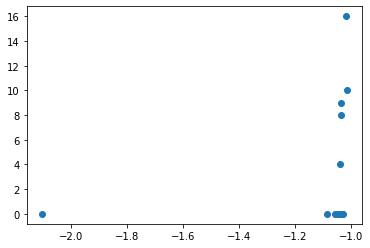

In [10]:
plt.scatter(mis, accs)
plt.show()

The results are not visualized in the best way, but some interesting difference already emerge. This is perhaps mainly due to the small N and non-randomized sampling. Many accuracies are 0, while the MI's are extremely close (with one single exception).